# Image Captioning

Observing that people who are blind have relied on (human-based) image captioning services to learn about images they take for nearly a decade, we introduce the first image captioning dataset to represent this real use case. This new dataset, which we call VizWiz-Captions, consists of 39,181 images originating from people who are blind that are each paired with 5 captions. Our proposed challenge addresses the task of predicting a suitable caption given an image. Ultimately, we hope this work will educate more people about the technological needs of blind people while providing an exciting new opportunity for researchers to develop assistive technologies that eliminate accessibility barriers for blind people (https://vizwiz.org/tasks-and-datasets/image-captioning/).

The goal of this Challenge is to create a single model similar to https://arxiv.org/pdf/1411.4555.pdf to get reasonable results on this task.

In [90]:
from vizwiz_api.vizwiz import VizWiz
from vizwiz_eval_cap.eval import VizWizEvalCap
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as io
import numpy as np
from sklearn.preprocessing import StandardScaler
import pylab
import torch
from torchvision import transforms

import json
from jsonpath_ng import jsonpath, parse
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [62]:
 def get_cap_img(set_name, vizwiz=None):
    # be sure if `vizwiz` is set, that it contains the `set_name` dataset
    if (set_name != 'train') and (set_name != 'val') and (set_name != 'test'):
        raise Exception('only "train", "val" or "test" is a valid `set_name`')
    ann_path = './annotations/'+set_name+'.json'
    img_path_prefix = './images/'+set_name+'/'
    
    if not isinstance(vizwiz, VizWiz):
        vizwiz = VizWiz(ann_path, ignore_rejected=True, ignore_precanned=True)
    
    img_paths = {}
    for i in vizwiz.imgs:
        img_key = vizwiz.imgs[i]['id']
        img_paths[img_key] = img_path_prefix+vizwiz.imgs[i]['file_name']

    cap_img = {}
    for i in vizwiz.anns:
        cap_key = vizwiz.anns[i]['caption']
        img_id = vizwiz.anns[i]['image_id']
        cap_img[cap_key] = img_paths[img_id]
        
    return cap_img, img_paths

In [84]:
ann_train = './annotations/train.json'
vizwiz_train = VizWiz(ann_train, ignore_rejected=True, ignore_precanned=True)
cap_img_train, img_paths_train = get_cap_img('train', vizwiz_train)
cap_train = list(cap_img_train.keys())

loading annotations into memory...
Done (t=0.33s)
creating index...
index created! imgs = 23431, anns = 100575


caption: ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.


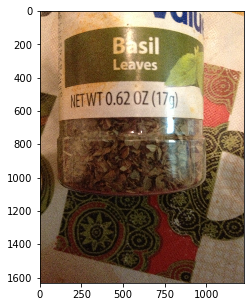

In [85]:
cap1 = cap_train[0]
print('caption:', cap1)
img1 = Image.open(cap_img_train[cap1])
_ = plt.figure(figsize=(7,5))
_ = plt.imshow(img1)

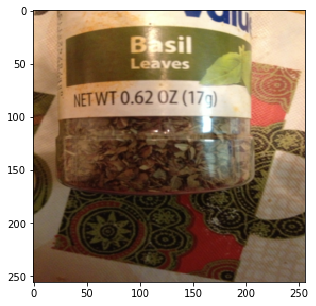

In [86]:
resize = transforms.Compose([transforms.Resize((256,256))])
img1_resized = resize(img1)
_ = plt.figure(figsize=(7,5))
_ = plt.imshow(img1_resized)

In [110]:
np.asarray(img1).mean(axis=(0,1))

array([126.28421761, 100.63797227,  73.66911514])

In [88]:
# loading all images will take a while (needs about 4GB RAM)
imgs_train = {}
for i in img_paths_train:
    img = Image.open(img_paths_train[i])
    imgs_train[i] = np.asarray(resize(img))

In [106]:
imgs_train_tensor = np.array(list(imgs_train.values()))

In [113]:
train_channel_means = imgs_train_tensor.mean(axis=(0,1,2))
train_channel_means

array([121.36099081, 108.30417503,  94.85418927])

In [179]:
std_batch_size = 1000
std_sum = 0
std_n = 256*256*imgs_train_tensor.shape[0]
std_idx = np.arange(0,imgs_train_tensor.shape[0]+std_batch_size, std_batch_size)
for i in range(std_idx.shape[0]-1):
    start_idx, end_idx = std_idx[i], std_idx[i+1]
    std_batch = imgs_train_tensor[start_idx:end_idx]
    batch_sum = np.sum((std_batch - train_channel_means)**2, axis=(0,1,2))
    std_sum += batch_sum
    
std_sum

array([8.27217303e+12, 7.65479820e+12, 7.64026895e+12])

In [180]:
train_channels_sigmas = np.sqrt(std_sum / std_n)
train_channels_sigmas

array([73.39634405, 70.60435592, 70.53731856])

In [182]:
with open('./images/train_means.npy', 'wb') as f:
    np.save(f, train_channel_means)
    
with open('./images/train_sigmas.npy', 'wb') as f:
    np.save(f, train_channels_sigmas)